# Move data between GPU and CPU

**Goal:** Understand how to move tensors and models between CPU and GPU, do it efficiently, and avoid common pitfalls.

**What you'll learn**
- Checking device availability & GPU info
- Moving tensors and models: `.to()`, `.cuda()`, `.cpu()`
- Avoiding device mismatch errors



## 0) Setup & Environment Checks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device index:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("Running on CPU-only environment. GPU-specific cells will safely skip.")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device count: 1
Current device index: 0
Device name: Tesla T4


## 1) Devices & Moving Tensors

Key APIs:
- `tensor.device` to see where a tensor lives
- `tensor.to(device)` is the general way to move between devices/dtypes
- Shorthands: `tensor.cuda()` and `tensor.cpu()`
- You **cannot** perform ops across devices directly

In [ ]:
# Create a CPU tensor
x_cpu = torch.randn(3, 3)
print("x_cpu.device:", x_cpu.device)

# Move to GPU if available
if torch.cuda.is_available():
    x_gpu = x_cpu.to("cuda")
    print("x_gpu.device:", x_gpu.device)

    # Device mismatch example (will raise if uncommented)
    try:
        _ = x_cpu + x_gpu   # This will throw if devices differ
    except RuntimeError as e:
        print("Expected device mismatch error:", str(e).split('\n')[0])
else:
    print("CUDA not available; skipping GPU move demo.")


x_cpu.device: cpu
x_gpu.device: cuda:0
Expected device mismatch error: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!



## 2) Moving Models

- Use `model.to(device)` to move all parameters and buffers
- Ensure **inputs and the model** are on the **same** device
- Typical pattern:
  ```python
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  for data, target in loader:
      data, target = data.to(device), target.to(device)
      out = model(data)
  ```


In [ ]:
# Load datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

print(f"Training set shape: {trainset.data.shape}")
print(f"Testing set shape: {testset.data.shape}")

Training set shape: torch.Size([60000, 28, 28])
Testing set shape: torch.Size([10000, 28, 28])


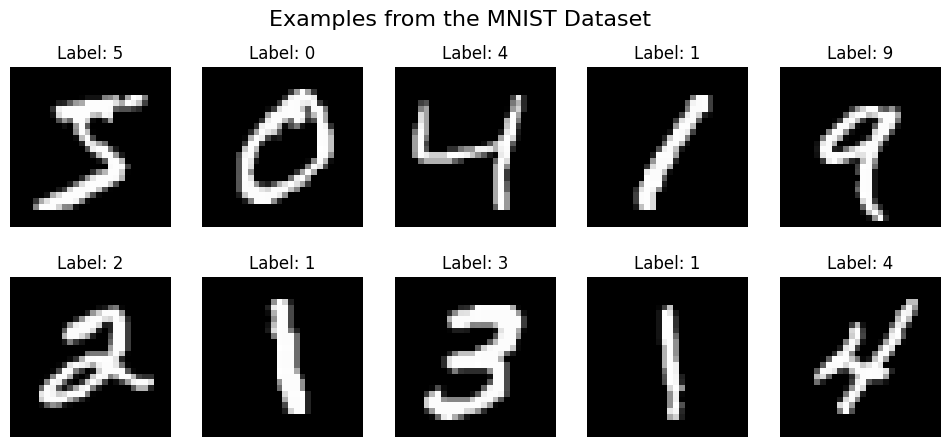

In [ ]:
# Let's visualize a few examples from the training set.
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # trainset.data[i] is a 28x28 tensor
    plt.imshow(trainset.data[i], cmap='gray')
    plt.title(f"Label: {trainset.targets[i]}")
    plt.axis('off')
plt.suptitle("Examples from the MNIST Dataset", fontsize=16)
plt.show()

In [ ]:
# Preprocess and flatten the data
def preprocess_data(dataset):
    # normalize pixel values and flatten images
    data = (dataset.data / 255.0) - 0.5
    flattened_data = data.view(data.shape[0], -1) # flatten from [N, 28, 28] to [N, 784]
    targets = dataset.targets
    return flattened_data, targets

x_train, y_train = preprocess_data(trainset)
x_test, y_test = preprocess_data(testset)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyNet().to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

with torch.no_grad():
  logits = model(x_train)
  print("Model+data device:", next(model.parameters()).device, x_train.device, "-> OK")


Model+data device: cuda:0 cuda:0 -> OK


### 3) Building Flexible Architectures with `nn.ModuleList`

For the homework, you need to explore the trade-offs between network architectures: is it better for a network to be shallow and wide (few layers, many nodes) or deep and narrow (many layers, few nodes)?

To facilitate this, we need a network definition that is more flexible than `TinyNet`. The professor recommended using `torch.nn.ModuleList`. This is the standard way to build dynamic models in PyTorch, as it properly registers all sub-modules (layers) so that `model.parameters()` can find them for training. A regular Python list of layers will not work correctly.

Let's define a `FlexibleNet` that accepts the number of layers and their width as arguments.

In [ ]:
class FlexibleNet(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_width):
        """
        A flexible fully-connected neural network.

        Args:
            input_size (int): The dimensionality of the input features (e.g., 784 for MNIST).
            output_size (int): The number of output classes (e.g., 10 for MNIST).
            num_layers (int): The number of hidden layers (the 'k' from the homework description).
            hidden_width (int): The number of neurons in each hidden layer (the 'm').
        """
        super().__init__()

        # Create a list to hold the layers
        layers = []

        # Add the first hidden layer (from input size to hidden width)
        layers.append(nn.Linear(input_size, hidden_width))
        layers.append(nn.ReLU())

        # Add the remaining hidden layers (k-1 of them)
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_width, hidden_width))
            layers.append(nn.ReLU())

        # We can use nn.Sequential to wrap the list of layers.
        # It will automatically call them in order.
        self.hidden_layers = nn.Sequential(*layers)

        # The final output layer
        self.output_layer = nn.Linear(hidden_width, output_size)

    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)

        # Pass input through the sequence of hidden layers
        x = self.hidden_layers(x)

        # Pass through the final output layer to get logits
        logits = self.output_layer(x)
        return logits

# --- Example Usage ---

# Example 1: A "shallow and wide" network (k=2, m=512)
shallow_wide_net = FlexibleNet(input_size=784, output_size=10, num_layers=2, hidden_width=512)
print("Shallow and wide network (k=2, m=512)")
print(shallow_wide_net)

# Example 2: A "deep and narrow" network (k=8, m=64)
deep_narrow_net = FlexibleNet(input_size=784, output_size=10, num_layers=8, hidden_width=64)
print("\nDeep and narrow network (k=8, m=64)")
print(deep_narrow_net)

Shallow and wide network (k=2, m=512)
FlexibleNet(
  (hidden_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=512, out_features=10, bias=True)
)

Deep and narrow network (k=8, m=64)
FlexibleNet(
  (hidden_layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=64, bias=True)
    (15

### A Note on "Parameter Budget"

When comparing different architectures, it's often useful to keep the total number of trainable parameters roughly constant. This ensures a fairer comparison of how the *shape* of the network affects performance, rather than just its overall size.

For your homework, as you vary the depth (`k`) and width (`m`), try to do so while keeping the total parameter count within a certain "budget" (`P`). This is a key part of the experimental design.

# Save and load PyTorch models

In this lecture, we'll learn:
- Why saving models is important
- Different ways to save in PyTorch
- How to save and load **model weights** properly
- Best practices when working with `torch.save` and `torch.load`


### A Preview of Other Training Concepts

#### Optimizer Choice
In this notebook, we use `optim.SGD` (Stochastic Gradient Descent), which is a fundamental optimizer. In practice, more advanced optimizers like `Adam` are very popular because they often converge faster and are less sensitive to the choice of learning rate. The professor will cover these in future lectures. Switching optimizers in PyTorch is very simple:

```python
# A common alternative to SGD
# optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam typically uses a smaller learning rate

Epoch 1, Average Loss: 0.3520
Epoch 2, Average Loss: 0.1524
Epoch 3, Average Loss: 0.1135
Epoch 4, Average Loss: 0.0951
Epoch 5, Average Loss: 0.0808


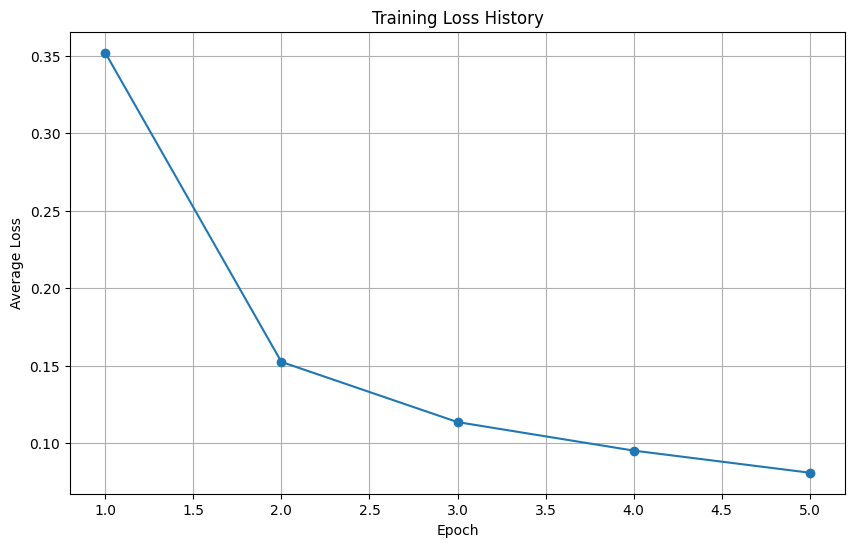

In [ ]:
import torch.utils.data as data

# initialize
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

# 1. Create a Dataset
train_dataset = data.TensorDataset(x_train, y_train)

# 2. Create a DataLoader
batch_size = 32
epochs = 5
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 3. Adapt the training loop to iterate directly over the loader
loss_history = []
for epoch in range(epochs):
    total_loss = 0
    # The loader provides the batches automatically
    for x_batch, y_batch in train_loader:
        logits = model(x_batch)
        loss = loss_function(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # The number of batches is len(train_loader)
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

Save:
- Model weights
- Optimizer state
- Current epoch / training step
- Loss history


In [ ]:
# Save model + optimizer + epoch info
checkpoint = {
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss_history": loss_history
}
torch.save(checkpoint, "checkpoint.pth")

print("Training checkpoint saved!")


Training checkpoint saved!


**When loading back:** The architecture **must match** when loading weights.  
Otherwise, PyTorch will raise shape mismatch errors.




In [ ]:
# Load checkpoint
checkpoint = torch.load("checkpoint.pth")

loaded_model = TinyNet().to(device)
loaded_optimizer = optim.SGD(loaded_model.parameters(), lr=0.2)

loaded_model.load_state_dict(checkpoint["model_state_dict"])
loaded_optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"]
loss = checkpoint["loss_history"][-1]

print(f"Checkpoint loaded (Epoch {start_epoch}, Loss={loss})")


Checkpoint loaded (Epoch 4, Loss=0.080839552622661)


Epoch 5, Average Loss: 0.0718
Epoch 6, Average Loss: 0.0640
Epoch 7, Average Loss: 0.0565
Epoch 8, Average Loss: 0.0507
Epoch 9, Average Loss: 0.0473
Epoch 10, Average Loss: 0.0439
Epoch 11, Average Loss: 0.0384
Epoch 12, Average Loss: 0.0349
Epoch 13, Average Loss: 0.0313
Epoch 14, Average Loss: 0.0292
Epoch 15, Average Loss: 0.0266


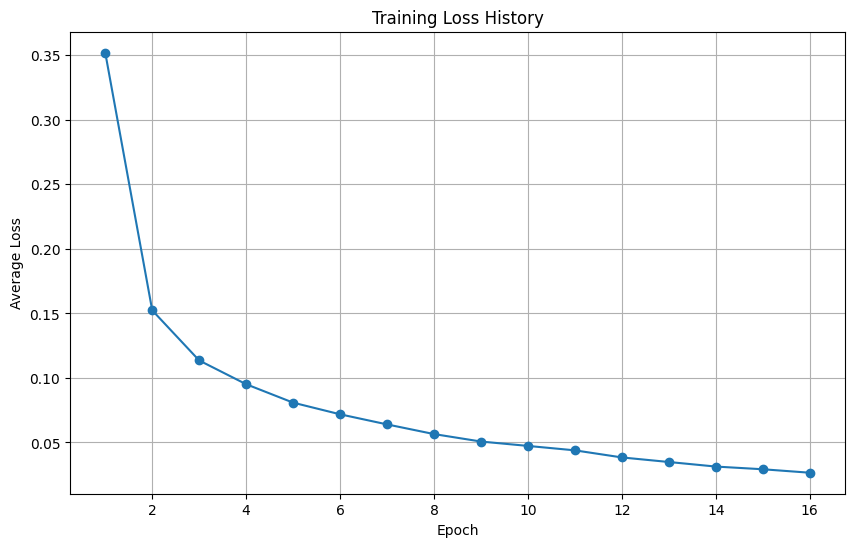

In [ ]:
loss_history = checkpoint["loss_history"]
epochs = 15
for epoch in range(start_epoch, epochs):
    total_loss = 0
    # The loader provides the batches automatically
    for x_batch, y_batch in train_loader:
        logits = loaded_model(x_batch)
        loss = loss_function(logits, y_batch)

        loaded_optimizer.zero_grad()
        loss.backward()
        loaded_optimizer.step()

        total_loss += loss.item()

    # The number of batches is len(train_loader)
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

Side Note: For tracking training details (loss, gradient, metrics), you can use TensorBoard or Wandb for larger projects.

## Final Experiment: Comparing Architectures with FlexibleNet

Now that we understand the mechanics of training, saving, and loading models, let's put everything together in a comprehensive experiment that directly addresses the professor's question from the homework.

**Goal**: Compare the training dynamics of a "shallow and wide" network versus a "deep and narrow" network.

**Steps**:
1.  Instantiate two `FlexibleNet` models with roughly similar parameter counts but different shapes.
2.  Train each model for a set number of epochs.
3.  Plot their loss histories on the same graph to visually compare their convergence.

In [ ]:
# --- Step 1: Define the two models ---

# Ensure we are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model 1: A shallow network with 2 hidden layers of 256 neurons each
shallow_wide_model = FlexibleNet(input_size=784, output_size=10, num_layers=2, hidden_width=256).to(device)

# Model 2: A deeper network with 5 hidden layers of 115 neurons each
# Note: These architectures are chosen to have a roughly similar number of total parameters for a fair comparison.
deep_narrow_model = FlexibleNet(input_size=784, output_size=10, num_layers=5, hidden_width=115).to(device)


# --- Step 2: Train each model and record history ---

def train_experiment_model(model, train_loader, model_name, epochs=10, lr=0.1):
    """A helper function to train a model and return its loss history."""
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    history = []
    model.train() # Set model to training mode

    print(f"--- Training Model: {model_name} ---")
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            # Data is already on the device from earlier cells
            logits = model(x_batch)
            loss = loss_function(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
        history.append(avg_loss)
    print("Training complete.\n")
    return history

# Run the training for both models
sw_history = train_experiment_model(shallow_wide_model, train_loader, "Shallow & Wide (2x256)")
dn_history = train_experiment_model(deep_narrow_model, train_loader, "Deep & Narrow (5x115)")


# --- Step 3: Plot the comparison graph ---

plt.figure(figsize=(12, 7))
epochs_range = range(1, len(sw_history) + 1)

plt.plot(epochs_range, sw_history, marker='o', linestyle='-', label='Shallow-Wide (2x256)')
plt.plot(epochs_range, dn_history, marker='s', linestyle='--', label='Deep-Narrow (5x115)')

plt.title("Training Loss Comparison: Shallow vs. Deep Networks", fontsize=16)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.xticks(epochs_range)
plt.show()

--- Training Model: Shallow & Wide (2x256) ---
Epoch 1/10, Average Loss: 0.3972
Epoch 2/10, Average Loss: 0.1524
Epoch 3/10, Average Loss: 0.1087
Epoch 4/10, Average Loss: 0.0860
Epoch 5/10, Average Loss: 0.0718
Epoch 6/10, Average Loss: 0.0600
Epoch 7/10, Average Loss: 0.0494
Epoch 8/10, Average Loss: 0.0440
Epoch 9/10, Average Loss: 0.0375
Epoch 10/10, Average Loss: 0.0313
Training complete.

--- Training Model: Deep & Narrow (5x115) ---
Epoch 1/10, Average Loss: 0.8555
Epoch 2/10, Average Loss: 0.2077
Epoch 3/10, Average Loss: 0.1477
Epoch 4/10, Average Loss: 0.1184
Epoch 5/10, Average Loss: 0.0961
Epoch 6/10, Average Loss: 0.0827


## Visualizing Model Predictions

Let's take our trained model and see how it performs on a few examples from the test set. We'll show the image, the true label, and the model's prediction. We can color the title green for correct predictions and red for incorrect ones.

In [ ]:
# Switch the model to evaluation mode
loaded_model.eval()

# Get a few random samples from the test set
num_samples = 10
indices = random.sample(range(len(x_test)), num_samples)
sample_images = x_test[indices].to(device)
sample_labels = y_test[indices]

with torch.no_grad():
    # Get model predictions (logits)
    predictions = loaded_model(sample_images)
    # Get the class with the highest score
    predicted_classes = torch.argmax(predictions, dim=1)

# Move data to CPU for plotting
sample_images_cpu = sample_images.cpu()
predicted_classes_cpu = predicted_classes.cpu()

plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    # Reshape the flattened image back to 28x28
    image = sample_images_cpu[i].view(28, 28)
    plt.imshow(image, cmap='gray')

    true_label = sample_labels[i].item()
    pred_label = predicted_classes_cpu[i].item()

    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Experiment: Comparing Architectures

How do different architectures ("shallow and wide" vs. "deep and narrow") compare? We can train two different `FlexibleNet` models with a similar parameter budget and plot their loss curves on the same graph to see the difference in training dynamics.

In [ ]:
#reusable training function
def train_model(model, train_loader, epochs=5, lr=0.1):
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    history = []
    model.train() # Set model to training mode
    print(f"Training {model.__class__.__name__} for {epochs} epochs")
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            logits = model(x_batch)
            loss = loss_function(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
        history.append(avg_loss)
    return history

# Define and train two different models
# Model 1: Shallow and Wide
shallow_wide_model = FlexibleNet(input_size=784, output_size=10, num_layers=2, hidden_width=256).to(device)
# Model 2: Deep and Narrow
deep_narrow_model = FlexibleNet(input_size=784, output_size=10, num_layers=5, hidden_width=115).to(device)

# Note: These two models have roughly similar parameter counts to make the comparison fairer.

# Train both models
sw_history = train_model(shallow_wide_model, train_loader, epochs=10)
dn_history = train_model(deep_narrow_model, train_loader, epochs=10)

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sw_history, marker='o', linestyle='-', label='Shallow-Wide (2x256)')
plt.plot(range(1, 11), dn_history, marker='s', linestyle='--', label='Deep-Narrow (5x115)')
plt.title("Training Loss Comparison: Shallow vs. Deep Networks")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.show()